### **Part Two**
## **Lane Detection Using Hough Transform**

In [268]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## **First Test Image**

### Step 1. Preprocessing

In [17]:
image1 = cv2.cvtColor(cv2.imread('lane1.jpg'), cv2.COLOR_BGR2GRAY)
image2 = cv2.cvtColor(cv2.imread('lane2.jpg'), cv2.COLOR_BGR2GRAY)

image1_rgb = cv2.cvtColor(cv2.imread('lane1.jpg'), cv2.COLOR_BGR2RGB)
image2_rgb = cv2.cvtColor(cv2.imread('lane2.jpg'), cv2.COLOR_BGR2RGB)

In [231]:
def display_image(image, title):
    plt.figure(figsize=(10, 5))
    plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

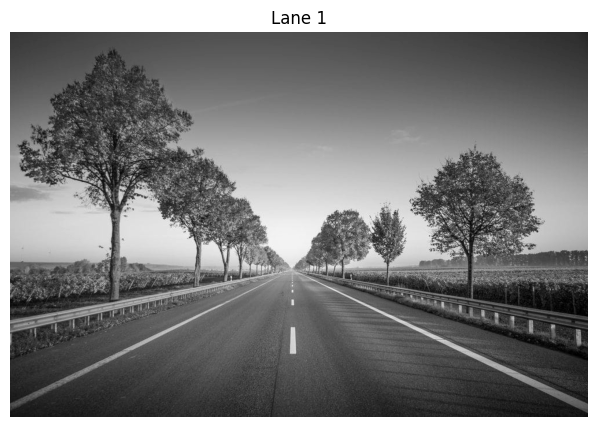

In [238]:
display_image(image1, "Lane 1")

### Step 2: Applying filters

1. Median Smoothing filter applied
2. Edge Detection Canny filter applied

In [239]:
def apply_filters(image, smoothing_kernel, lower_th, higher_th):
    smoothed_median = cv2.medianBlur(image, smoothing_kernel)
    edges = cv2.Canny(smoothed_median, lower_th, higher_th)
    return edges


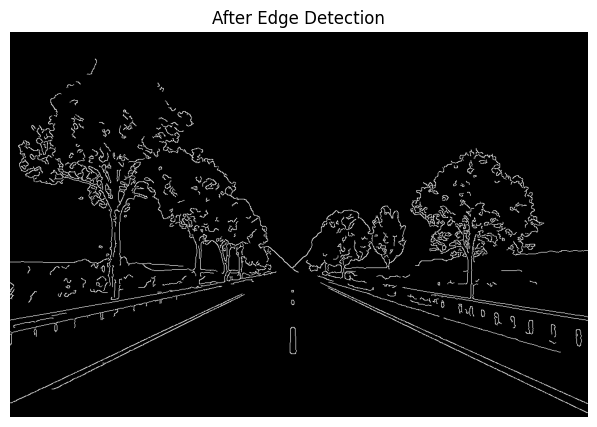

In [240]:
image1_filtered = apply_filters(image1, 5, 100, 200)
display_image(image1_filtered, "After Edge Detection")

In [241]:
print(image1_filtered.shape)

(667, 1000)


### Step 3: Extracting Region Of Interest

In [255]:
def get_roi(image, polygon):
    mask = np.zeros_like(image) 
    cv2.fillPoly(mask, polygon, 255)
    roi = cv2.bitwise_and(image, mask)
    return roi

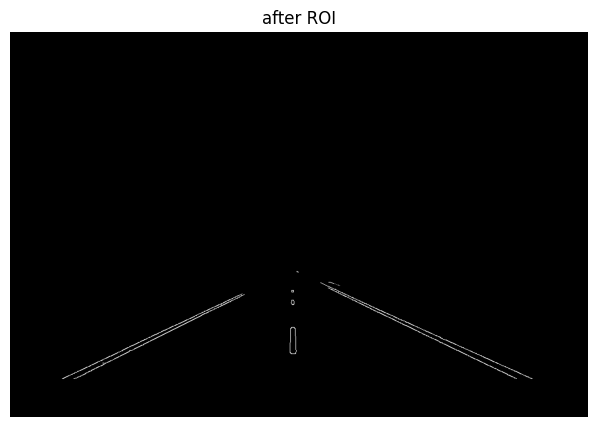

In [270]:
height1, width1 = image1_filtered.shape

polygon1 = np.array([[
    (0, 0.9*height1), (width1, 0.9*height1), (width1//2, 0.62*height1)
]], dtype=np.int32)


image1_roi = get_roi(image1_filtered, polygon1)
display_image(get_roi(image1_filtered, polygon1), "after ROI")

### Step 4: Accumulation using Hough Transform

In [245]:
def apply_hough_transform(roi, height, width):
    # Hough Transform parameters
    theta_range = np.deg2rad(np.arange(0, 181))  #nsw +d2r?
    diag_len = int(np.sqrt(width**2 + height**2)) 
    rho_range = np.arange(-diag_len, diag_len, 1)  #nsw
    H = np.zeros((len(rho_range), len(theta_range)), dtype=np.int32)  # Accumulator

    y_idxs, x_idxs = np.nonzero(roi)  #since we need to process only edge pixels

    # Voting
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for t_idx, theta in enumerate(theta_range):
            rho = int(x * np.cos(theta) + y * np.sin(theta))
            rho_idx = np.where(rho_range == rho)[0][0]  # (array([4]),) so used 00
            H[rho_idx, t_idx] += 1

    plt.figure(figsize=(10, 5))
    plt.imshow(H, cmap="hot", aspect="auto", extent=[0, 180, -diag_len, diag_len])
    plt.title("Hough Transform Accumulator")
    plt.xlabel("Theta (degrees)")
    plt.ylabel("Rho (pixels)")
    plt.colorbar(label="Votes")
    plt.show()

    return theta_range, rho_range, H


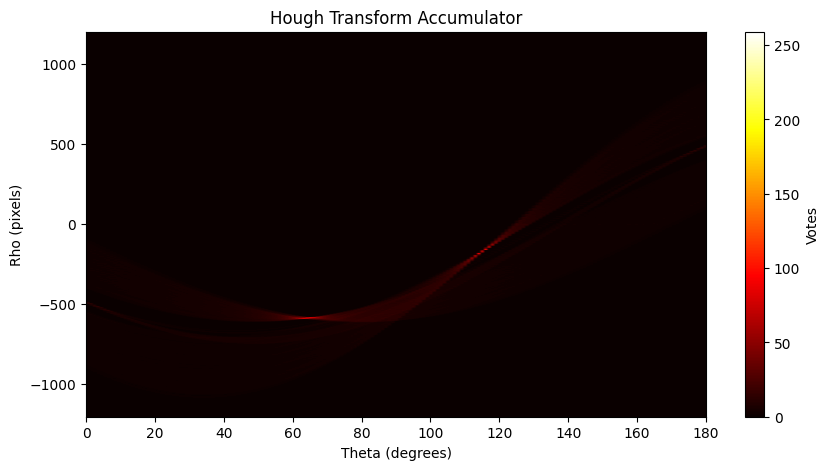

In [258]:
theta_range, rho_range, H = apply_hough_transform(image1_roi, height1, width1)

### Step 5: Refining Coordinates and HT Post-Processing

In [247]:
def detect_lane(image, height, theta_range, rho_range, H, threshold, rho_tolerance, theta_tolerance, y_minx , y_maxx):
    # Extract peaks from the accumulator
    threshold = 32 
    lines = np.argwhere(H > threshold)

    lines = sorted(lines, key=lambda idx: H[idx[0], idx[1]], reverse=True)
    filtered_lines = []
    rho_theta_used = set() #avoiding duplicates

    # rho_tolerance = 100 
    # theta_tolerance = np.deg2rad(10) 

    for rho_idx, theta_idx in lines:
        rho = rho_range[rho_idx]
        theta = theta_range[theta_idx]
        if any(abs(rho - r) < rho_tolerance and abs(theta - t) < theta_tolerance 
            for r, t in rho_theta_used):
            continue  
        rho_theta_used.add((rho, theta))
        filtered_lines.append((rho_idx, theta_idx))


    image_with_lines = image.copy()
    y_min = int(y_minx * height) #parameter here
    y_max = height * y_maxx

    for rho_idx, theta_idx in filtered_lines:
        rho = rho_range[rho_idx]
        theta = theta_range[theta_idx]
        a, b = np.cos(theta), np.sin(theta)
        x1 = int((rho - y_min * b) / a)
        x2 = int((rho - y_max * b) / a)
        
        cv2.line(image_with_lines, (x1, y_min), (x2, y_max), (0, 255, 0), 2)

    plt.figure(figsize=(10, 5))
    plt.imshow(image_with_lines)
    plt.title("Lane Detection")
    plt.axis("off")
    plt.show()

    return image_with_lines


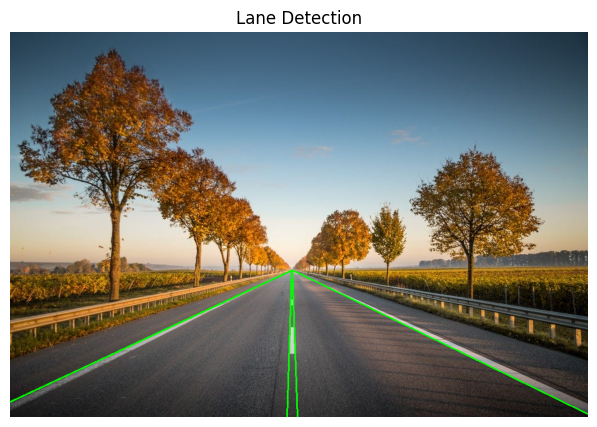

In [259]:
image_with_lines = detect_lane(image1_rgb,height1, theta_range, rho_range, H, 32, 100, np.deg2rad(10) , 0.62, 1)

In [249]:
def compare_output(image_before, image_after):
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))
    ax[0].imshow(image_before)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(image_after)
    ax[1].set_title("Lane Detection")
    ax[1].axis("off")

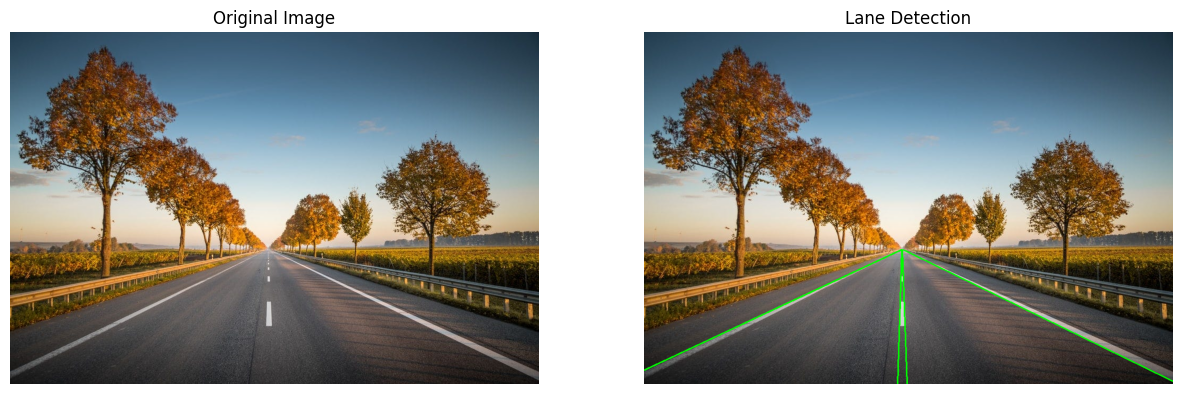

In [260]:
compare_output(image1_rgb, image_with_lines)

----------------------------------------------------------------------------------

## **Second Test Image**

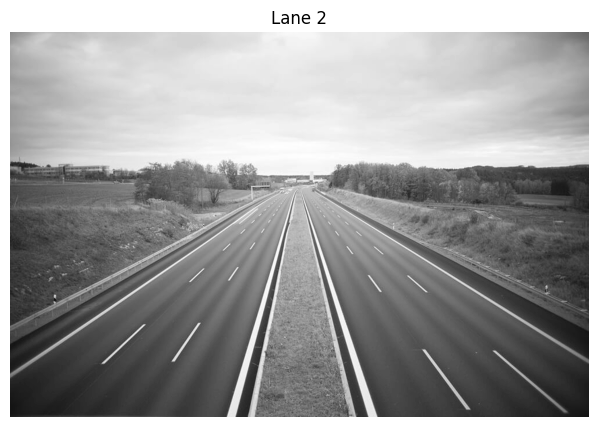

In [251]:
display_image(image2, "Lane 2")

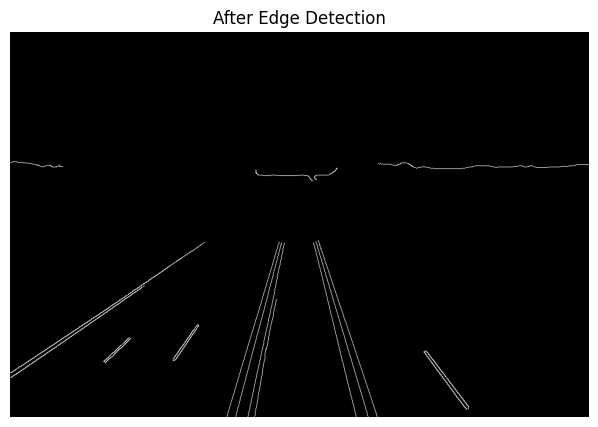

In [261]:
image2_filtered = apply_filters(image2, 9, 150, 400)
display_image(image2_filtered, "After Edge Detection")

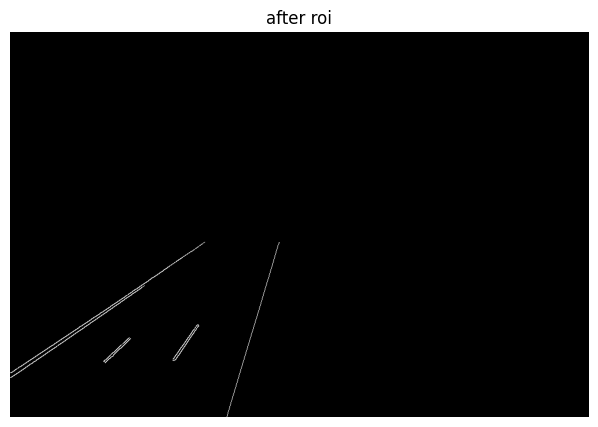

In [262]:
height2, width2 = image2_filtered.shape

polygon2 = np.array([
    [(0, height2), (width2//2 - 120, height2), (width2//2 - 25, height2//2), (0, height2//2)]
], dtype=np.int32)


image2_roi = get_roi(image2_filtered, polygon2)
display_image(get_roi(image2_filtered, polygon2), "after roi")

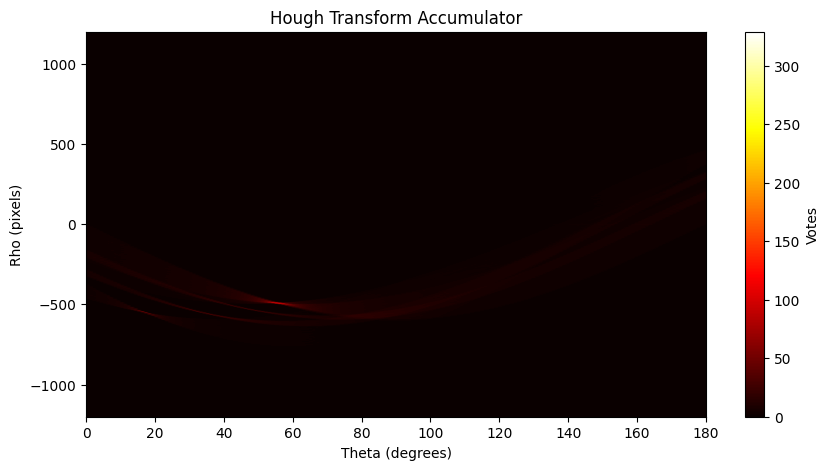

In [263]:
theta_range2, rho_range2, H2 = apply_hough_transform(image2_roi, height2, width2)

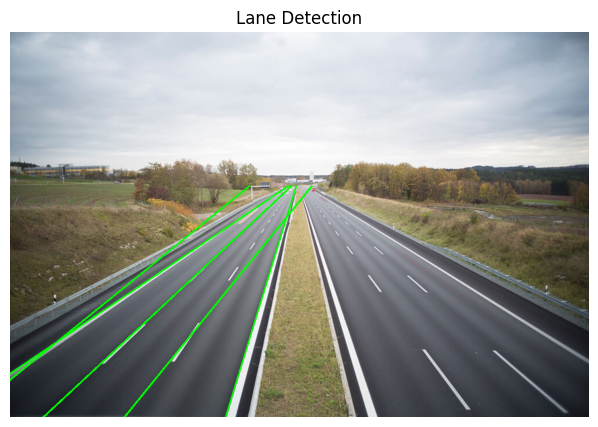

In [266]:
image2_with_lines = detect_lane(image2_rgb, height2, theta_range2, rho_range2, H2, 200, 20, 50, 0.4, 1)

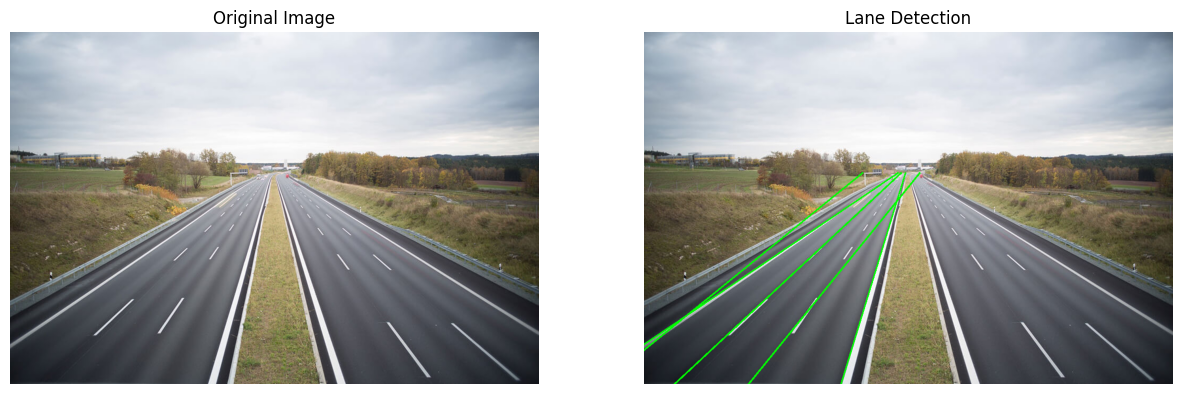

In [267]:
compare_output(image2_rgb, image2_with_lines)

----------------------------------------------------------------
